## Sentiment analysis on women's clothes reviews 


The project concerns sentiment analysis of the womens's clothes reviews to determined whether the product is recommended or not. In this approach we used a recommendation based on customers rating. We assigned the values from the ranking to the positive, neutral and negative values. We used different machine learning algorithms to get more accurate predictions. The following classification algorithms have been used: Logistic Regression, Naive Bayes, Support Vector Machine (SVM), Random Forest and Ada Boosting. 

### Dataset
The dataset comes from Woman Clothing Review that can be find at https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews. 


### Importing packages and loading data

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
df = pd.read_csv('C:\\Python Scripts\\NLP_projekty\\reviews_class.csv', header=0,index_col=0)
df.head()

,Rating,Recommended,Review,Class
0,4,1,Absolutely wonderful - silky and sexy and comf...,Positive
1,5,1,Love this dress! it's sooo pretty. i happene...,Positive
2,3,0,I had such high hopes for this dress and reall...,Neutral
3,5,1,"I love, love, love this jumpsuit. it's fun, fl...",Positive
4,5,1,This shirt is very flattering to all due to th...,Positive


In [3]:
text = df[['Class', 'Review']]
text.head()

,Class,Review
0,Positive,Absolutely wonderful - silky and sexy and comf...
1,Positive,Love this dress! it's sooo pretty. i happene...
2,Neutral,I had such high hopes for this dress and reall...
3,Positive,"I love, love, love this jumpsuit. it's fun, fl..."
4,Positive,This shirt is very flattering to all due to th...


First observations:

In [4]:
text.shape

(22641, 2)

In [5]:
#missing values:
text.isnull().sum()

Class     0
Review    0
dtype: int64

Checking Proportion Target Class Variable:

In [6]:
text['Class'].value_counts()

Positive    17448
Neutral      2823
Negative     2370
Name: Class, dtype: int64

Number of characters in each review:

In [7]:
text['length'] = text.Review.apply(len)
text.head()

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Class,Review,length
0,Positive,Absolutely wonderful - silky and sexy and comf...,53
1,Positive,Love this dress! it's sooo pretty. i happene...,303
2,Neutral,I had such high hopes for this dress and reall...,500
3,Positive,"I love, love, love this jumpsuit. it's fun, fl...",124
4,Positive,This shirt is very flattering to all due to th...,192


Distribution of length in a chart:

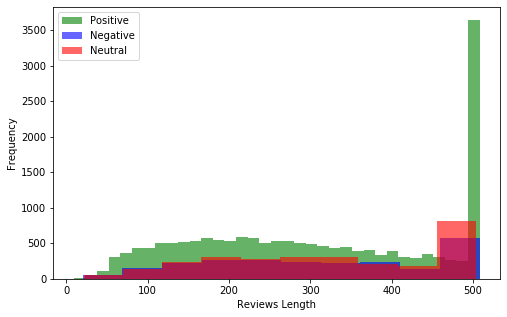

In [11]:
plt.figure(figsize=(8, 5))
text[text.Class == 'Positive'].length.plot(bins=35, kind='hist', color='green', label='Positive', alpha=0.6)
text[text.Class == 'Negative'].length.plot(kind='hist', color='blue', label='Negative', alpha=0.6)
text[text.Class == 'Neutral'].length.plot(kind='hist', color='red', label='Neutral', alpha=0.6)
plt.legend()
plt.xlabel("Reviews Length");

### Text Pre-processing

In this step we remove non-alphabetic characters, stopwords, numbers and apply lemmatizing for each line of text:

In [8]:
stop = stopwords.words('english')
print(stop[::10])

#clothing stopwords
clothes =['dress','color','wear','top','sweater','material','shirt','jeans','pant',
          'skirt','order','white','black','fabric','blouse','sleeve','even', 'jacket']

lem = WordNetLemmatizer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [9]:
def tokens(words):
    """Clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def stopwords(review):
    """Removing stopwords"""
    text = [word.lower() for word in review.split() if word.lower() not in stop and word.lower() not in clothes]
    return " ".join(text)

def numbers(text):
    """Removing numbers from text"""
    new_text = []
    for word in text.split():
        if not re.search('\d', word):
            new_text.append(word)
    return ' '.join(new_text)  

def lemma(text):
    """Applying lemmatizing"""
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)


In [10]:
text['Review'] = text['Review'].apply(tokens)
text['Review'] = text['Review'].apply(stopwords)
text['Review'] = text['Review'].apply(numbers)
text['Review'] = text['Review'].apply(lemma)

C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\PC\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [11]:
text.head()

,Class,Review,length
0,Positive,absolutely wonderful silky sexy comfortable,53
1,Positive,love sooo pretty happened find store glad bc n...,303
2,Neutral,high hope really wanted work initially ordered...,500
3,Positive,love love love jumpsuit fun flirty fabulous ev...,124
4,Positive,flattering due adjustable front tie perfect le...,192


### Models

We build and test the following classification models:

- Logistic Regression,
- Random Forest Classifier,
- Naive Bayes Classifier,
- SVM (Support Vector Machine),
- Ada Boosting.

To make the vectorizer => transformer => classifier easier to work with, we will use Pipeline class in Scilkit-Learn.

In [12]:
X = text['Review']
y = text['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

**Logistic regression**

In [13]:
model = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                  ('tfidf', TfidfTransformer()),
                  ('model',LogisticRegression()),
                  ])

model.fit(X_train, y_train)

ytest = np.array(y_test)
pred_y = model.predict(X_test)

C:\Users\PC\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [14]:
log_acc = accuracy_score(pred_y, y_test)
print('accuracy %s' % log_acc)
print(classification_report(ytest, pred_y))

accuracy 0.8050342238904835
              precision    recall  f1-score   support

    Negative       0.60      0.39      0.47       489
     Neutral       0.48      0.20      0.28       628
    Positive       0.84      0.98      0.90      3412

    accuracy                           0.81      4529
   macro avg       0.64      0.52      0.55      4529
weighted avg       0.77      0.81      0.77      4529



**Random forest**

In [15]:
model_rf = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                    ('clf-rf', RandomForestClassifier(n_estimators=50)),
                    ])

model_rf.fit(X_train, y_train)

ytest = np.array(y_test)
pred = model_rf.predict(X_test)

In [16]:
rf_acc = accuracy_score(pred, y_test)
print('accuracy %s' % rf_acc)
print(classification_report(ytest, pred))

accuracy 0.7783175093839699
              precision    recall  f1-score   support

    Negative       0.65      0.21      0.31       489
     Neutral       0.54      0.05      0.09       628
    Positive       0.79      0.99      0.88      3412

    accuracy                           0.78      4529
   macro avg       0.66      0.42      0.43      4529
weighted avg       0.74      0.78      0.71      4529



**Naive Bayes**

In [17]:
model_nb = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                   ('tfidf', TfidfTransformer()),
                   ('model',MultinomialNB()),
                   ])

model_nb.fit(X_train,y_train)

ytest = np.array(y_test)
preds = model_nb.predict(X_test)

In [18]:
nb_acc = accuracy_score(preds, y_test)
print('accuracy %s' % nb_acc)
print(classification_report(ytest, preds))

accuracy 0.7595495694413777
              precision    recall  f1-score   support

    Negative       0.80      0.05      0.09       489
     Neutral       0.33      0.01      0.01       628
    Positive       0.76      1.00      0.86      3412

    accuracy                           0.76      4529
   macro avg       0.63      0.35      0.32      4529
weighted avg       0.71      0.76      0.66      4529



**SVM**

In [20]:
model_svm = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1, 2))),
                    ('tfidf', TfidfTransformer()),
                    ('svm',LinearSVC()),
                    ])

model_svm.fit(X_train, y_train)

ytest = np.array(y_test)
y_predict = model_svm.predict(X_test)

In [21]:
svm_acc = accuracy_score(y_predict, y_test)
print('accuracy %s' % svm_acc)
print(classification_report(ytest, y_predict))

accuracy 0.8034886288363877
              precision    recall  f1-score   support

    Negative       0.54      0.44      0.49       489
     Neutral       0.45      0.25      0.32       628
    Positive       0.87      0.96      0.91      3412

    accuracy                           0.80      4529
   macro avg       0.62      0.55      0.57      4529
weighted avg       0.77      0.80      0.78      4529



**Ada Boosting**

In [23]:
model_ab = Pipeline([('vect', CountVectorizer(min_df=5, ngram_range=(1,2))),
                    ('tfidf', TfidfTransformer()),
                    ('ada', AdaBoostClassifier()),
                    ])

model_ab.fit(X_train, y_train)

ytest = np.array(y_test)
y_pred = model_ab.predict(X_test)

In [24]:
ab_acc = accuracy_score(y_pred, y_test)
print('accuracy %s' % ab_acc)
print(classification_report(ytest, y_pred))

accuracy 0.7807463016118349
              precision    recall  f1-score   support

    Negative       0.48      0.35      0.41       489
     Neutral       0.40      0.11      0.17       628
    Positive       0.82      0.97      0.89      3412

    accuracy                           0.78      4529
   macro avg       0.57      0.47      0.49      4529
weighted avg       0.73      0.78      0.74      4529



### Best model

We tested five different models and now, we check which one is the best:

In [25]:
models = pd.DataFrame({
                      'Model': ['Logistic Regression', 'Random Forest', 'Naive Bayes', 'SVM', 'Ada Boosting'],
                      'Score': [log_acc, rf_acc, nb_acc, svm_acc, ab_acc]})
models.sort_values(by='Score', ascending=False)

,Model,Score
0,Logistic Regression,0.805034
3,SVM,0.803489
4,Ada Boosting,0.780746
1,Random Forest,0.778318
2,Naive Bayes,0.759550


### Conclusion

This project was aimed to used sentiment analysis to determined product recommendation. In this case we used a recommendation based on customers rating. We assigned the values from the ranking to the positive, neutral and negative values. We tested a five models, which we have also used in the previous approach. The best model was also the Logistic Regression algorithm which reached accuracy equal to 80 %.